## 노드 타입과 패턴
* 실행 방식과 처티 패턴에 따라 구분되며, 성능과 구조에 큰 영향을 끼침

### 동기 노드 (Sync Node)
* 가장 기본적인 형태로, 작업이 순차적으로 실행되며 완료될 때까지 다음 단계로 진행되지 않음
* 간단한 계산이나, 즉시 완료되는 작업에 적합
* 직관적이고 디버깅이 용이함
* CPU집약적 작업 혹은 로컬데이터 처리에 사용됨

In [1]:
from langgraph.graph import StateGraph
from typing import TypedDict,Dict,Any

def sync_node(state) -> Dict[str,Any]:
    """
    동기 노드를 수행하는 함수
    순차적으로 실행되며 결과 즉시 반환함

    Args:
        state (_type_): 그래프의 전체 상태 값

    Returns:
        Dict[str,Any]: 업데이트할 필드가 포함된 딕셔너리

    """
    # 동기 작업 수행
    result = perform_sync_operation(state["input"])

    return {"output": result}

def perform_sync_operation(data):
    """동기 작업"""
    import time
    time.sleep(0.1)  # 시뮬레이션
    return f"Sync result: {data}"

### 비동기 노드 (Async Node)
* I/O 작업이나 외부 API 호출과 같이 대기 시간이 발생하는 작업에 적합
* 비동기 패턴 (`async/await`)을 활용하여 여러 작업을 동시해 실행
* 네트워크 요청, DB 쿼리, 파일 I/O 등에서 성능 향상 기대할 수 있음

In [ ]:
import asyncio
class State(TypedDict):
    input: str
    output: str
    additional_data:str
    
async def async_node(state:State) -> Dict[str,Any]:
    """
    비동기 작업을 수행하는 노드

    Args:
        state (_type_): 그래프의 전체 상태 값

    Returns:
        Dict[str,Any]: 업데이트할 필드가 포함된 딕셔너리
    """
    
    # 비동기 작업 수행
    result = await perform_async_operation(state["input"])

    # 여러 비동기 작업 동시 실행
    results = await asyncio.gather(
        fetch_data_1(),
        fetch_data_2(),
        fetch_data_3()
    )

    return {
        "output": result,
        "additional_data": results
    }
    
async def perform_async_operation(data):
    """비동기 작업"""
    await asyncio.sleep(0.1)  # 시뮬레이션
    return f"Async result: {data}"

async def fetch_data_1():
    await asyncio.sleep(0.05)
    return "data_1"

async def fetch_data_2():
    await asyncio.sleep(0.05)
    return "data_2"

async def fetch_data_3():
    await asyncio.sleep(0.05)
    return "data_3"

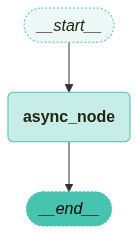

In [5]:
from langchain_teddynote.graphs import visualize_graph
from langgraph.graph import START,END
# Initiate Graph add Nodes
_graph = StateGraph(State)
_graph.add_node('async_node',async_node)

_graph.add_edge(START,"async_node")


_graph.add_edge("async_node",END)


# 그래프 시각화
graph = _graph.compile()
visualize_graph(graph)


In [ ]:
# Execute Graph
from pprint import pprint
init_config = State(
    {
        "input": "hello World!",
        "additional_data":"",
        "output":""
    }
)


In [19]:
# jupyter cell에선 에러 발생함
# cell 단위로 비동기로 실행되고 있기 때문에 (추정)
# async_node_test.py를 통해 결과 확인할 수 있음

# 7. 비동기 함수를 실행하고 ainvoke를 호출
async def run_async_graph():
    # `ainvoke`를 호출하여 비동기 실행을 시작합니다.
    # 입력 값은 `GraphState` 딕셔너리 형태여야 합니다.
    result = await graph.ainvoke(init_config)
    return result


### 조건부 노드
* 상태나 입력에 따라 다른 로직을 선택함
* 비즈니스 로직의 복잡성을 효과적으로 관리하며, 런타임 조건에 따라 다양한 처리 경로 제공함
* `데이터 크기에 따른 처리 속도 조절`, `사용자 권한에 따라 다른 접근 권한 방식` 등

In [ ]:
class CondState(TypedDict):
    input:str
    mode: str
    result:dict
    execution_time:str
    

def conditional_node(state:CondState) -> Dict[str, Any]:
    """
    조건부 노드 - 상태에 따라 다른 처리 수행
    """
    mode = state.get("mode", "default")

    if mode == "fast":
        # 빠른 처리
        result = quick_process(state)
        execution_time = "fast"
    elif mode == "thorough":
        # 정밀 처리
        result = thorough_process(state)
        execution_time = "slow"
    else:
        # 기본 처리
        result = default_process(state)
        execution_time = "normal"

    return {
        "result": result,
        "execution_time": execution_time,
        "mode_used": mode
    }

def quick_process(state):
    return {"status": "quick", "data": state.get("input", "")[:10]}

def thorough_process(state):
    return {"status": "thorough", "data": analyze_deeply(state.get("input", ""))}

def default_process(state):
    return {"status": "default", "data": state.get("input", "")}

def analyze_deeply(data):
    # 심층 분석 로직
    return f"Deeply analyzed: {data}"


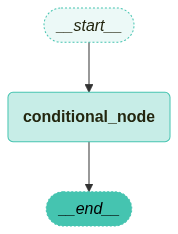

In [21]:
# Initiate Graph add Nodes
_cond_graph = StateGraph(CondState)
_cond_graph.add_node('conditional_node',conditional_node)

_cond_graph.add_edge(START,"conditional_node")


_cond_graph.add_edge("conditional_node",END)


# 그래프 시각화
cond_graph = _cond_graph.compile()
visualize_graph(cond_graph)


In [23]:
# Execute Graph
from pprint import pprint
init_config = CondState(
    {
        "input":"test",
        "mode":"fast",
        "result":{},
        "execution_time":""
    }
)
res = cond_graph.invoke(init_config)
pprint(res)

{'execution_time': 'fast',
 'input': 'test',
 'mode': 'fast',
 'result': {'data': 'test', 'status': 'quick'}}


### 검증 노드
* 데이터 품질과 시스템 안정성을 보장하는 역할
* 입력 데이터 유효성 검증, 오류 수집 하여 한번에 반환함
* 보안 취약점을 방지하고 다운스트림 노드의 안정성 보장

In [24]:
from typing import Optional

class ValidationState(TypedDict):
    input_data: Any
    validation_errors: list[str]
    is_valid: bool

def validation_node(state: ValidationState) -> Dict[str, Any]:
    """
    검증 노드 - 데이터 유효성 검사
    """
    input_data = state["input_data"]
    errors = []

    # 다양한 검증 수행
    if not input_data:
        errors.append("입력 데이터가 비어있습니다.")

    if isinstance(input_data, str):
        if len(input_data) < 3:
            errors.append("문자열이 너무 짧습니다 (최소 3자).")
        if len(input_data) > 1000:
            errors.append("문자열이 너무 깁니다 (최대 1000자).")
        if not input_data.isascii():
            errors.append("ASCII 문자만 허용됩니다.")

    elif isinstance(input_data, (int, float)):
        if input_data < 0:
            errors.append("음수는 허용되지 않습니다.")
        if input_data > 1000000:
            errors.append("값이 너무 큽니다 (최대 1,000,000).")

    elif isinstance(input_data, list):
        if len(input_data) == 0:
            errors.append("리스트가 비어있습니다.")
        if len(input_data) > 100:
            errors.append("리스트 항목이 너무 많습니다 (최대 100개).")

    # 검증 결과 반환
    return {
        "validation_errors": errors,
        "is_valid": len(errors) == 0
    }


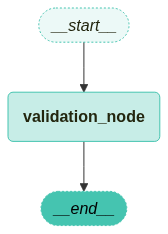

In [25]:
# Initiate Graph add Nodes
_valid_graph = StateGraph(ValidationState)
_valid_graph.add_node('validation_node',validation_node)

_valid_graph.add_edge(START,"validation_node")


_valid_graph.add_edge("validation_node",END)


# 그래프 시각화
valid_graph = _valid_graph.compile()
visualize_graph(valid_graph)


In [31]:
# Execute Graph
from pprint import pprint
init_config = ValidationState(
    {
        "input_data":"",
        "is_valid":False,
        "validation_errors":[]
    }
)

In [39]:
test_input = ["hello", "", 1000, 1000000]
for val in test_input:
    init_config['input_data'] = val
    res = valid_graph.invoke(init_config)
    print(f"""
          Value: {val}
          Result: {res}
          """
    )


          Value: hello
          Result: {'input_data': 'hello', 'validation_errors': [], 'is_valid': True}
          

          Value: 
          Result: {'input_data': '', 'validation_errors': ['입력 데이터가 비어있습니다.', '문자열이 너무 짧습니다 (최소 3자).'], 'is_valid': False}
          

          Value: 1000
          Result: {'input_data': 1000, 'validation_errors': [], 'is_valid': True}
          

          Value: 1000000
          Result: {'input_data': 1000000, 'validation_errors': [], 'is_valid': True}
          


### 클래스 기반 노드
* 아래의 경우에 해당할 때 유용함
  * 노드가 내부 상태를 유지할 필요가 있을 때
  * 복잡한 로직을 캡슐화 해야할 때
  * 여러 메서드를 통해 기능분리 필요할 때
* 생성자를 통한 초기설정 후, `__call__` 메서드 구현후 호출 가능한 객체로 만들어짐
  * 캐싱, 통계 수집, 성능 모니터링등의 기능을 노드 내부에서 자체적으로 관리할 수 있음

**장점**
* 상태 지속성
  * 처리 횟수 추적, 캐시 관리, 설정 저장 등의 객체들을 인스턴스 변수로 관리 가능함
* 메서드 분리
  * 각기 다른 처리방식을 별도의 메서드로 분리하여, 코드의 가독성과 유지보수성 향상
* 상속을 통한 기능확장 및 재사용성 향상

In [54]:
class ClassState(TypedDict):
    input:str
    processor_type:str
    processing_count:int
    cache:dict

class DataProcessorNode:
    """
    클래스 기반 노드
    상태를 가지고 복잡한 로직을 구현할 때 유용
    """

    def __init__(self, processor_type: str = "standard"):
        self.processor_type = processor_type
        self.processing_count = 0
        self.cache = {}

    def __call__(self, state: ClassState) -> Dict[str, Any]:
        """
        노드 실행 메서드
        클래스 인스턴스를 호출 가능하게 만듦
        """
        input_data = state["input"]

        # 캐시 확인
        cache_key = f"{self.processor_type}:{input_data}"
        if cache_key in self.cache:
            print(f"Cache hit for {cache_key}")
            return {"output": self.cache[cache_key], "from_cache": True}

        # 처리 수행
        if self.processor_type == "standard":
            result = self._standard_process(input_data)
        elif self.processor_type == "advanced":
            result = self._advanced_process(input_data)
        else:
            result = self._default_process(input_data)

        # 통계 업데이트
        self.processing_count += 1

        # 캐시 저장
        self.cache[cache_key] = result

        return {
            "output": result,
            "processor_type": self.processor_type,
            "total_processed": self.processing_count,
            "from_cache": False
        }

    def _standard_process(self, data):
        return f"Standard processed: {data}"

    def _advanced_process(self, data):
        return f"Advanced processed: {data}"

    def _default_process(self, data):
        return f"Default processed: {data}"

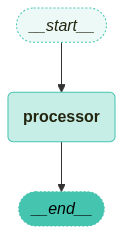

In [55]:
# Initiate Graph add Nodes
processor = DataProcessorNode()
_class_graph = StateGraph(ClassState)
_class_graph.add_node("processor", processor)

_class_graph.add_edge(START,"processor")


_class_graph.add_edge("processor",END)


# 그래프 시각화
class_graph = _class_graph.compile()
visualize_graph(class_graph)

In [56]:
# 사용 예시
init_config = ClassState(
    {
        "processor_type":"advanced",
        "processing_count":0,
        "cache": {},
        "input":"hello world"
        
    }
)
class_graph.invoke(init_config)

{'input': 'hello world',
 'processor_type': 'standard',
 'processing_count': 0,
 'cache': {}}

### 데코레이터 패턴 노드
* 기존 노드 함수에 추가기능을 동적으로 부여하는 패턴
* 유틸의 성격을 가진 기능들의 횡단 관심사 분리 가능

**`관심사의 분리`,`조합 가능성`**
* 비즈니스 로직과 인프라 관심사를 명확히 분리하여 코드의 의도를 더욱 명확하게 표현
* 여러 데코레이터를 조합하여 복합적인 기능 구현




In [57]:
from functools import wraps
import time

def timing_decorator(func):
    """노드 실행 시간 측정 데코레이터"""
    @wraps(func)
    def wrapper(state):
        start_time = time.time()
        result = func(state)
        execution_time = time.time() - start_time

        # 실행 시간 추가
        if isinstance(result, dict):
            result["execution_time"] = execution_time

        print(f"{func.__name__} executed in {execution_time:.3f} seconds")
        return result

    return wrapper

def error_handling_decorator(func):
    """에러 처리 데코레이터"""
    @wraps(func)
    def wrapper(state):
        try:
            return func(state)
        except Exception as e:
            print(f"Error in {func.__name__}: {e}")
            return {
                "error": str(e),
                "error_node": func.__name__,
                "status": "failed"
            }

    return wrapper

@timing_decorator
@error_handling_decorator
def decorated_node(state: State) -> Dict[str, Any]:
    """
    데코레이터가 적용된 노드
    자동으로 시간 측정과 에러 처리가 됨
    """
    # 의도적으로 느린 작업
    time.sleep(0.1)

    # 비즈니스 로직
    result = state["input"].upper() if isinstance(state["input"], str) else str(state["input"])

    return {"output": result}


### 팩토리 패턴 노드
`코드 중복 감소` </br>
`노드 생성로직 중앙화` </br>
`유연성과 확장성` </br>
* 런타입에 다양한 타입의 노드를 동적으로 생성하는 패턴
* 설정이나 조건에 따라 다른 동작을 하는 노드를 일관된 인터페이스로 생성
* 노드 타입과 매겨변수를 입력값으로 받아 해당하는 노드 함수 생성후 반환
* 새로운 노드 타입을 추가할 때, 팩토리 함수만 확장하면 됨
* 설정 파일이나 사용자 입력에 따라 동적인 그래프 구조 구성 가능함
* 비슷한 기능을 하는 노드들의 공통 패턴 추상화 후 재사용 가능함


In [ ]:
def create_processing_node(node_type: str, **kwargs):
    """
    노드 팩토리 함수
    다양한 타입의 노드를 동적으로 생성
    """

    if node_type == "transformer":
        def transformer_node(state: State) -> Dict[str, Any]:
            transform_func = kwargs.get("transform_func", lambda x: x)
            input_field = kwargs.get("input_field", "input")
            output_field = kwargs.get("output_field", "output")

            transformed = transform_func(state[input_field])
            return {output_field: transformed}

        return transformer_node

    elif node_type == "filter":
        def filter_node(state: State) -> Dict[str, Any]:
            filter_func = kwargs.get("filter_func", lambda x: True)
            items_field = kwargs.get("items_field", "items")

            filtered = [item for item in state[items_field] if filter_func(item)]
            return {items_field: filtered}

        return filter_node

    elif node_type == "aggregator":
        def aggregator_node(state: State) -> Dict[str, Any]:
            agg_func = kwargs.get("agg_func", sum)
            values_field = kwargs.get("values_field", "values")
            result_field = kwargs.get("result_field", "result")

            aggregated = agg_func(state[values_field])
            return {result_field: aggregated}

        return aggregator_node

    else:
        raise ValueError(f"Unknown node type: {node_type}")

# 팩토리로 노드 생성
uppercase_node = create_processing_node(
    "transformer",
    transform_func=lambda x: x.upper(),
    input_field="text",
    output_field="uppercase_text"
)

positive_filter = create_processing_node(
    "filter",
    filter_func=lambda x: x > 0,
    items_field="numbers"
)

sum_aggregator = create_processing_node(
    "aggregator",
    agg_func=sum,
    values_field="scores",
    result_field="total_score"
)

# 그래프에 추가
# graph.add_node("uppercase", uppercase_node)
# graph.add_node("filter_positive", positive_filter)
# graph.add_node("calculate_sum", sum_aggregator)


**고급 기능 및 실용적 이점** 

* **서브그래프와 Private State**
  * 서브그래프는 독립적인 상태를 가지면서도 부모 그래프와 필요한 정보만 공유할 수 있어, 대규모 멀티 에이전트 시스템 관리에 유용함
* **에러 처리 및 복구**
  * 각 노드에서 예외 처리가 가능하여 시스템의 안정성과 신뢰성을 높임
* **성능 최적화**
  * 노드별 실행 시간을 모니터링하고, 병렬 처리나 캐싱을 통해 성능을 최적화